<a href="https://colab.research.google.com/github/kochlisGit/Physics-Informed-Neural-Network-PINN-/blob/main/TF_PINN_PDE_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*PINNs* have the ability to solve **systems** of PDE equations. Solving a PDE System can be very difficult or time-consuming, because it includes many dependent variables and multiple functions that need to be approximated. For instance:

1.   $\frac{du_1}{dt}=\frac{du^2_1}{dx^2} + u_3 sin(\pi x)$

2.   $\frac{du_2}{dt}=\frac{du^2_2}{dx^2} + u_3 cos(\pi x)$

3.   $𝑢_1 sin(𝜋𝑥) + 𝑢_2 cos(𝜋𝑥) − 𝑒^{-t} = 0$

in domain $x \in [0.0, 3.0], t \in [0.0, 3.0]$ with boundary conditions:



1.   $u_1(x, 0) = sin(\pi x)$
2.   $u_2(x, 0) = cos(\pi x)$
3.   $\frac{du_1(x,0)}{dt} = -sin(\pi x)$
4.   $\frac{du_2(x,0)}{dt} = -cos(\pi x)$$

In this system of equations, we are mainly interested in computing the function $u_1(x, t)$. However, $u_1(x, t)$ is dependent by functions $u_2(x, t), u_3(x, t)$
This seems to be a very challenging PDE system. However, it is proved that PINNs can approximate the solution of the above system with very high accuracy. The solutions of the above system is:

1.    $u_1(x, t) = e^{-t} sin(\pi x)$
2.    $u_2(x, t) = e^{-t} cos(\pi x)$
3.    $u_3(x, t) = e^{-t} (1+\pi^2)$


In [1]:
import tensorflow as tf
import numpy as np

In [30]:
num_domain = 4096
num_test = 512
minval = [0.0, 0.0]
maxval = [3.0, 3.0]

def generate_uniform_data(num_domain, minval, maxval):
  data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=0)
  return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)

x_train = generate_uniform_data(num_domain, minval, maxval)
x_test = generate_uniform_data(num_test, minval, maxval)
x_train.shape, x_test.shape

(TensorShape([4096, 2]), TensorShape([512, 2]))

Like the previous examples, we will need to compute the Jacobian & Hessian matrix in order to compute the error of the above system. We may notice that by using the Jacobian matrix, we can compute any derivative with respect to every variable. For example:

$\frac{du_1}{dx} = J[0,0]$ and $\frac{du_1}{dt} = J[0,1]$.

So we only need to compute the gradients for y=NN(x) once, where NN(x) is the forward output of our neural network! In this case, we will modify the functions *jacobian* and *hessian* in order to compute the gradients once and store them in a HashMap (**Dict**). This way, we can **re-use the gradients for each equation and optimize the training time**.

# Jabocian Matrix

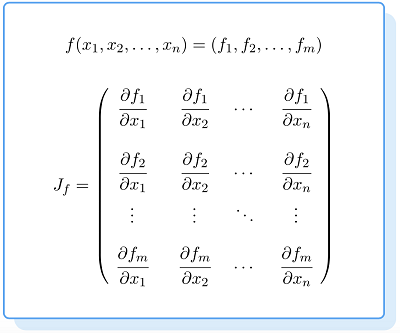

# Hessian Matrix

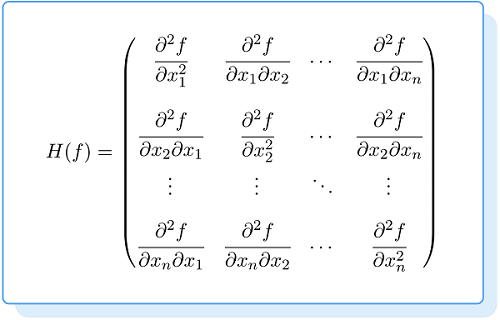


# Jacobian without Hashing

```
def jacobian(tape, y, x, i=0, j=0):
  if y.shape[1] > 1:
    y = y[:, i : i + 1]

  grads = tape.gradient(y, x)
  return grads[:, j : j + 1]
  ```

# Hessian without Hashing

```
def hessian(tape, y, x, i=0, j=0, component=0):
  if y.shape[1] > 1:
    y = y[:, i : i + 1]

  jacobian_grads = tape.gradient(y, x)[:, i : i + 1]
  hessian_grads = tape.gradient(jacobian_grads, x)
  return hessian_grads[:, j : j + 1]
```



Let's add some hashing, in order to re-use the gradients, if needed.

**Params**
- **tape**: The tf.GradientTape object that computes the gradients of the outputs with respects of inputs.
- **y**: The outputs "y" of the operation `y = model(x)`.
- **x**: The inputs "x" of the operation `y = model(x)`.
- **i**: The row of the matrix (*Jacobian or Hessian*)
- **j**: The column of the matrix (*Jacobian or Hessian*)
- **component**: The function of which the gradients will be computed (`u1: 0, u2: 1`)
- **key**: The hashing key, which is computed from the combination of y and x.

In [74]:
J = {}
def jacobian(tape, y, x, i=0, j=0, key=None):
  if key is None:
    key = (y.ref(), x.ref())

  if y.shape[1] > 1:
    y = y[:, i : i + 1]

  if not key in J:
    J[key] = {}
  if not i in J[key]:
    grads = tape.gradient(y, x)
    J[key][i] = grads
  return J[key][i][:, j : j + 1]

H = {}
def hessian(tape, y, x, i=0, j=0, component=0):
  key = (y.ref(), x.ref())
  first_order_grads = jacobian(tape, y, x, component, i, key)

  if key not in H:
    H[key] = {}
  if component not in H[key]:
    H[key][component] = {}
  if i not in H[key][component]:
    second_order_grads = tape.gradient(first_order_grads, x)
    H[key][component][i] = second_order_grads
  return H[key][component][i][:, j : j + 1]

In [72]:
def extract_input_vars(inputs):
  x = inputs[:, 0: 1]
  t = inputs[:, 1: 2]
  return x, t

def extract_output_functions(y):
  u1 = y[:, 0: 1]
  u2 = y[:, 1: 2]
  u3 = y[:, 2: 3]
  return u1, u2, u3

def pde_system(tape, x, y):
  u1, u2, u3 = extract_output_functions(y)
  var_x, var_t = extract_input_vars(x)

  du1_t = jacobian(tape, y, x, i=0, j=1)
  du2_t = jacobian(tape, y, x, i=1, j=1)
  du1_xx = hessian(tape, y, x, i=0, j=0, component=0)
  du2_xx = hessian(tape, y, x, i=0, j=0, component=1)

  eq1 = du1_t - du1_xx - u3*tf.math.sin(np.pi * var_x)
  eq2 = du2_t - du2_xx - u3*tf.math.cos(np.pi * var_x)
  eq3 = u1*tf.math.sin(np.pi * var_x) + u2*tf.math.cos(np.pi * var_x) - tf.math.exp(-var_t)
  return tf.concat([eq1, eq2, eq3], axis=1)

In [73]:
def bc_u1(x):
  var_x, _ = extract_input_vars(x)
  return tf.math.sin(np.pi*var_x)

def bc_u2(x):
  var_x, _ = extract_input_vars(x)
  return tf.math.cos(np.pi*var_x)

def bc_du1(x):
  var_x, _ = extract_input_vars(x)
  return -tf.math.sin(np.pi*var_x)

def bc_du2(x):
  var_x, _ = extract_input_vars(x)
  return -tf.math.cos(np.pi*var_x)

def solution(x):
  var_x, var_t = extract_input_vars(x)
  u1 = tf.math.exp(-var_t) * tf.math.sin(np.pi * var_x)
  u2 = tf.math.exp(-var_t) * tf.math.cos(np.pi * var_x)
  u3 = tf.math.exp(-var_t) * (1 + np.pi**2)
  return tf.concat([u1, u2, u3], axis=1)

x_bc = tf.Variable(x_train)
x_bc[:, 1].assign(tf.zeros(shape=[x_bc.shape[0]]))

<tf.Variable 'UnreadVariable' shape=(4096, 2) dtype=float32, numpy=
array([[0.6330464 , 0.        ],
       [2.11803   , 0.        ],
       [2.40019   , 0.        ],
       ...,
       [2.7562017 , 0.        ],
       [0.09513831, 0.        ],
       [1.01101   , 0.        ]], dtype=float32)>

In [75]:
n_inputs = 2
n_outputs = 3
hidden_units = [50, 50, 50, 50]
activation = 'tanh'

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((n_inputs,)))

for units in hidden_units:
  model.add(tf.keras.layers.Dense(units=units, activation=activation))

model.add(tf.keras.layers.Dense(units=n_outputs))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 50)                150       
                                                                 
 dense_21 (Dense)            (None, 50)                2550      
                                                                 
 dense_22 (Dense)            (None, 50)                2550      
                                                                 
 dense_23 (Dense)            (None, 50)                2550      
                                                                 
 dense_24 (Dense)            (None, 3)                 153       
                                                                 
Total params: 7,953
Trainable params: 7,953
Non-trainable params: 0
_________________________________________________________________


In [77]:
def test_inputs():
  y_train = model(x_train)
  y_test = model(x_test)

  print('\n--- Testing inputs ---')
  print('\nTraining inputs:', x_train)
  print('\nTraining outputs:', y_train)
  print('\nEvaluation inputs:', x_test)
  print('\nEvaluation outputs:', y_test)

def test_bcs():
  with tf.GradientTape(persistent=True) as tape:
    y = model(x_bc, training=True)
    u1_bc = y[:, 0: 1]
    u2_bc = y[:, 1: 2]
    du1_t_bc = jacobian(tape, y, x_bc, i=0, j=1)
    du2_t_bc = jacobian(tape, y, x_bc, i=1, j=1)

  print('\n--- Testing boundary conditions ---')
  print('\nBC input:', x_bc)
  print('\nBC output', y)
  print('\nBC of u1:', u1_bc)
  print('\nBC of u2:', u1_bc)
  print('\nBC of du1_t:', du1_t_bc)
  print('\nBC of du2_t:', du2_t_bc)

def test_losses():
  with tf.GradientTape(persistent=True) as tape_domain:
    y_train = model(x_train, training=True)
    errors = pde_system(tape_domain, x_train, y_train)

  with tf.GradientTape(persistent=True) as tape_bc:
    y_bc = model(x_bc, training=True)
    u1_bc = y_bc[:, 0: 1]
    u2_bc = y_bc[:, 1: 2]
    du1_t_bc = jacobian(tape_bc, y_bc, x_bc, i=0, j=1)
    du2_t_bc = jacobian(tape_bc, y_bc, x_bc, i=1, j=1)

  domain_mean_losses = tf.math.reduce_mean(tf.math.square(errors), axis=0)
  domain_total_mean_loss = tf.math.reduce_mean(domain_mean_losses, axis=0)
  loss_u1 = tf.math.reduce_mean(tf.math.square(u1_bc - bc_u1(x_bc)), axis=0)[0]
  loss_u2 = tf.math.reduce_mean(tf.math.square(u2_bc - bc_u2(x_bc)), axis=0)[0]
  loss_du1 = tf.math.reduce_mean(tf.math.square(du1_t_bc - bc_du1(x_bc)), axis=0)[0]
  loss_du2 = tf.math.reduce_mean(tf.math.square(du2_t_bc - bc_du2(x_bc)), axis=0)[0]
  total_loss = domain_total_mean_loss + loss_u1 + loss_u2 + loss_du1 + loss_du2

  print('\n--- Testing losses ---')
  print('\nTesting domain errors:', errors)
  print('\nTesting domain mean losses:', domain_mean_losses)
  print('\nTesting total domain mean loss:', domain_total_mean_loss)
  print('\nTesting loss of u1-bcs:', loss_u1)
  print('\nTesting loss of u2-bcs:', loss_u2)
  print('\nTesting loss of du1-bcs:', loss_du1)
  print('\nTesting loss of du2_t-bcs:', loss_du2)
  print('\nTesting total loss:', total_loss)

def test_solution():
  print('\n--- Testing solution ---')
  print('\nTesting domain errors:', solution(x_train))

test_inputs()
test_bcs()
test_losses()
test_solution()


--- Testing inputs ---

Training inputs: <tf.Variable 'Variable:0' shape=(4096, 2) dtype=float32, numpy=
array([[0.6330464 , 0.6330464 ],
       [2.11803   , 2.11803   ],
       [2.40019   , 2.40019   ],
       ...,
       [2.7562017 , 2.7562017 ],
       [0.09513831, 0.09513831],
       [1.01101   , 1.01101   ]], dtype=float32)>

Training outputs: tf.Tensor(
[[-0.16319206  0.08628783  0.18769218]
 [-0.3748796   0.22495344  0.32350507]
 [-0.39366317  0.24881688  0.3225546 ]
 ...
 [-0.4122589   0.27803248  0.31710514]
 [-0.02594845  0.01412409  0.03171227]
 [-0.24094753  0.12638244  0.2581645 ]], shape=(4096, 3), dtype=float32)

Evaluation inputs: <tf.Variable 'Variable:0' shape=(512, 2) dtype=float32, numpy=
array([[0.6330464 , 0.6330464 ],
       [2.11803   , 2.11803   ],
       [2.40019   , 2.40019   ],
       ...,
       [0.23787296, 0.23787296],
       [0.4770459 , 0.4770459 ],
       [1.925     , 1.925     ]], dtype=float32)>

Evaluation outputs: tf.Tensor(
[[-0.16319206  0.08628

In [78]:
epochs = 20000
learning_rate = 0.0005

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

for i in range(epochs + 1):
  with tf.GradientTape() as tape_model:
    with tf.GradientTape(persistent=True) as tape_domain:
      y_train = model(x_train, training=True)
      domain_errors = pde_system(tape_domain, x_train, y_train)

    with tf.GradientTape(persistent=True) as tape_bcs:
      y_bc = model(x_bc, training=True)
      du1_t_bc = jacobian(tape_bcs, y_bc, x_bc, i=0, j=1)
      du2_t_bc = jacobian(tape_bcs, y_bc, x_bc, i=1, j=1)
    u1_bc = y_bc[:, 0: 1]
    u2_bc = y_bc[:, 1: 2]

    domain_mean_losses = tf.math.reduce_mean(tf.math.square(domain_errors), axis=0)
    domain_total_mean_loss = tf.math.reduce_mean(domain_mean_losses, axis=0)
    loss_u1 = tf.math.reduce_mean(tf.math.square(u1_bc - bc_u1(x_bc)), axis=0)[0]
    loss_u2 = tf.math.reduce_mean(tf.math.square(u2_bc - bc_u2(x_bc)), axis=0)[0]
    loss_du1 = tf.math.reduce_mean(tf.math.square(du1_t_bc - bc_du1(x_bc)), axis=0)[0]
    loss_du2 = tf.math.reduce_mean(tf.math.square(du2_t_bc - bc_du2(x_bc)), axis=0)[0]
    total_train_mse_loss = domain_total_mean_loss + loss_u1 + loss_u2 + loss_du1 + loss_du2

  model_update_gradients = tape_model.gradient(total_train_mse_loss, model.trainable_variables)
  optimizer.apply_gradients(
    zip(model_update_gradients, model.trainable_variables)
  )

  del tape_domain, tape_bcs

  if i % 1000 == 0:
    y_preds = model(x_test)
    y_true = solution(x_test)
    errors = y_preds - y_true
    test_mse_mean_losses = tf.math.reduce_mean(tf.math.square(errors), axis=0)
    print('Epoch: {}\tTrain Loss = {},\tTest Loss = {}'.format(i, domain_mean_losses.numpy(), test_mse_mean_losses.numpy()))

Epoch: 0	Train Loss = [0.03974378 0.05398791 0.2575662 ],	Test Loss = [ 0.14426956  0.10616456 19.06314   ]
Epoch: 1000	Train Loss = [0.00044387 0.00033955 0.00051211],	Test Loss = [6.0356776e-03 1.1616416e-02 1.4600947e+01]
Epoch: 2000	Train Loss = [4.4964185e-05 4.0343097e-05 1.3704150e-04],	Test Loss = [3.6434918e-03 5.4735313e-03 1.4164449e+01]
Epoch: 3000	Train Loss = [1.0556585e-05 1.8312225e-05 7.2138711e-05],	Test Loss = [3.2672051e-03 4.2237067e-03 1.4013189e+01]
Epoch: 4000	Train Loss = [1.1765272e-05 5.6781930e-05 4.6417932e-05],	Test Loss = [3.0861616e-03 3.6608034e-03 1.3869204e+01]
Epoch: 5000	Train Loss = [2.5159237e-05 2.0179452e-05 3.3210163e-05],	Test Loss = [2.8973864e-03 3.3252102e-03 1.3700095e+01]
Epoch: 6000	Train Loss = [2.3197922e-06 5.5363284e-06 2.2426013e-05],	Test Loss = [2.6315937e-03 3.0213839e-03 1.3513732e+01]
Epoch: 7000	Train Loss = [6.3152806e-06 8.4911098e-06 1.9736670e-05],	Test Loss = [2.4272972e-03 2.7676784e-03 1.3336361e+01]
Epoch: 8000	Train L

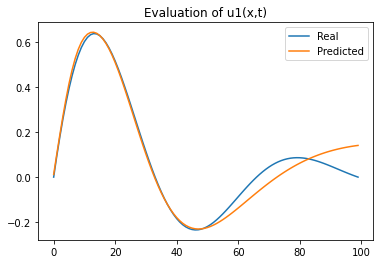

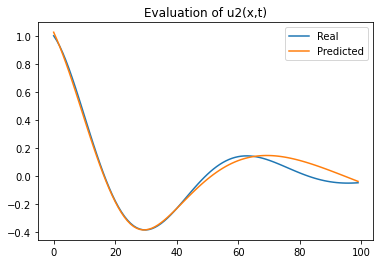

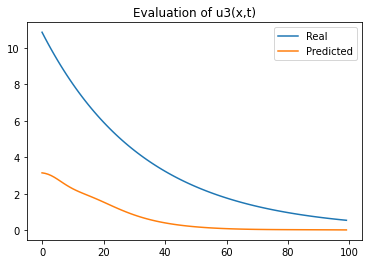

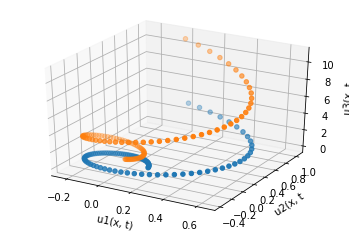

In [80]:
import numpy as np
import matplotlib.pyplot as plt

x_eval = np.linspace([0.0, 0.0], [3.0, 3.0], 100)
y_true = solution(x_eval)
y_pred = model(x_eval)

plt.plot(y_true[:, 0: 1])
plt.plot(y_pred[:, 0: 1])
plt.title('Evaluation of u1(x,t)')
plt.legend(['Real', 'Predicted'])
plt.show()

plt.plot(y_true[:, 1: 2])
plt.plot(y_pred[:, 1: 2])
plt.title('Evaluation of u2(x,t)')
plt.legend(['Real', 'Predicted'])
plt.show()

plt.plot(y_true[:, 2: 3])
plt.plot(y_pred[:, 2: 3])
plt.title('Evaluation of u3(x,t)')
plt.legend(['Real', 'Predicted'])
plt.show()

ax = plt.figure().add_subplot(projection='3d')
ax.scatter(y_pred[:, 0: 1], y_pred[:, 1: 2], y_pred[:, 2: 3])
ax.scatter(y_true[:, 0: 1], y_true[:, 1: 2], y_true[:, 2: 3])
ax.set_xlabel('u1(x, t)')
ax.set_ylabel('u2(x, t')
ax.set_zlabel('u3(x, t')
plt.show()